Set Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

from torcheval.metrics.functional import multiclass_accuracy, multiclass_f1_score

Set Data Image

In [2]:
data_dir = './dataset'

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [3]:
train_ds, val_ds, test_ds = random_split(dataset, [0.7, 0.2, 0.1])

print(f"Train set: {len(train_ds)} samples")
print(f"Valid set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")
print(f"Classes: {dataset.classes}")

Train set: 29256 samples
Valid set: 8358 samples
Test set: 4179 samples
Classes: ['Drowsy', 'Non Drowsy']


In [4]:
subset_train = Subset(train_ds, range(1000))
train_dl = DataLoader(subset_train, batch_size=128, shuffle=True, num_workers=4)
subset_val = Subset(val_ds, range(1000))
val_dl = DataLoader(subset_val, batch_size=128, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

In [ ]:
def plot_images_grid(dataloader, mean, std):
    for images, labels in dataloader:
        break
    _, axes = plt.subplots(3, 3, figsize=(6, 6))
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    for ax, image, label in zip(axes.flatten(), images, labels):            
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        image = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
        ax.imshow(image)
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
print("Train set"); plot_images_grid(train_dl, mean, std);
print("Valid set"); plot_images_grid(val_dl, mean, std);
print("Test set"); plot_images_grid(test_dl, mean, std);

Train set


Model Set Up

In [5]:

import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer
num_classes = 2  # Replace with the actual number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()

C:\Users\thame\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thame\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Utils Set Up

In [6]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

In [7]:
def plot_predictions(images, labels, predictions, class_names):
    images = images.cpu()
    labels = labels.cpu()
    predictions = predictions.cpu()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, ax in enumerate(axes):
        img = images[idx].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}")
        ax.axis('off')
    plt.show()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4):
    # Set loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        # val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model saved!")

    print("Training complete.")
    return model, train_losses, val_losses

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / total, correct / total

In [9]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

trained_model = train_model(model, train_dl, val_dl, device, epochs=10)


Epoch 1/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:21<00:00, 32.68s/it]


Train Loss: 0.5516, Train Acc: 0.7250
Val   Loss: 0.4011, Val   Acc: 0.8240
✅ Best model saved!

Epoch 2/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.32s/it]


Train Loss: 0.2370, Train Acc: 0.9100
Val   Loss: 0.1902, Val   Acc: 0.9320
✅ Best model saved!

Epoch 3/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.28s/it]


Train Loss: 0.0858, Train Acc: 0.9750
Val   Loss: 0.0797, Val   Acc: 0.9690
✅ Best model saved!

Epoch 4/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.36s/it]


Train Loss: 0.0462, Train Acc: 0.9860
Val   Loss: 0.0546, Val   Acc: 0.9820
✅ Best model saved!

Epoch 5/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:17<00:00, 32.22s/it]


Train Loss: 0.0309, Train Acc: 0.9910
Val   Loss: 0.0375, Val   Acc: 0.9870
✅ Best model saved!

Epoch 6/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.34s/it]


Train Loss: 0.0195, Train Acc: 0.9920
Val   Loss: 0.0364, Val   Acc: 0.9840

Epoch 7/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.28s/it]


Train Loss: 0.0254, Train Acc: 0.9910
Val   Loss: 0.0220, Val   Acc: 0.9910
✅ Best model saved!

Epoch 8/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.32s/it]


Train Loss: 0.0184, Train Acc: 0.9940
Val   Loss: 0.0274, Val   Acc: 0.9950
✅ Best model saved!

Epoch 9/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.31s/it]


Train Loss: 0.0119, Train Acc: 0.9970
Val   Loss: 0.0189, Val   Acc: 0.9940

Epoch 10/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:18<00:00, 32.30s/it]


Train Loss: 0.0193, Train Acc: 0.9920
Val   Loss: 0.0337, Val   Acc: 0.9840
Training complete.


In [11]:
import torch
from torchvision import models

# Define the number of output classes
NUM_CLASSES = len(dataset.classes)  # Ensure dataset is already defined

# Load the best trained model safely
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

# ✅ Use `weights_only=True` to avoid security issues
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.to(device)
model.eval()

print(f"✅ Model loaded successfully! Ready for {NUM_CLASSES} classes.")

✅ Model loaded successfully! Ready for 2 classes.


In [12]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = (correct / total) * 100
print(f"🎯 Test Accuracy: {test_accuracy:.2f}%")

🎯 Test Accuracy: 98.68%


In [13]:
from sklearn.metrics import classification_report

# Convert predictions and labels to numpy arrays
print("📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

📊 Classification Report:

              precision    recall  f1-score   support

      Drowsy       0.98      1.00      0.99      2228
  Non Drowsy       1.00      0.98      0.99      1951

    accuracy                           0.99      4179
   macro avg       0.99      0.99      0.99      4179
weighted avg       0.99      0.99      0.99      4179



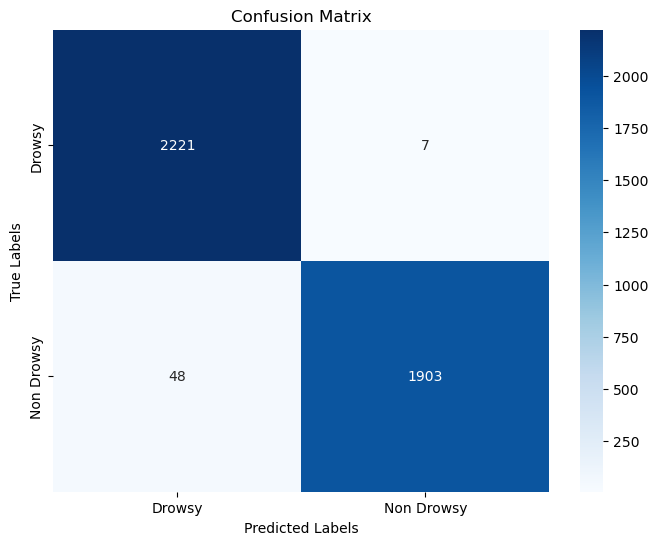

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:19<00:00, 32.43s/it]


Train Loss: 0.0083, Train Acc: 0.9960
Val   Loss: 0.0858, Val   Acc: 0.9740
✅ Best model saved!

Epoch 2/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:19<00:00, 32.44s/it]


Train Loss: 0.0050, Train Acc: 0.9970
Val   Loss: 0.0166, Val   Acc: 0.9960
✅ Best model saved!

Epoch 3/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:20<00:00, 32.58s/it]


Train Loss: 0.0063, Train Acc: 0.9970
Val   Loss: 0.0138, Val   Acc: 0.9930

Epoch 4/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:20<00:00, 32.56s/it]


Train Loss: 0.0084, Train Acc: 0.9970
Val   Loss: 0.0258, Val   Acc: 0.9900

Epoch 5/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:20<00:00, 32.51s/it]


Train Loss: 0.0018, Train Acc: 1.0000
Val   Loss: 0.0219, Val   Acc: 0.9900

Epoch 6/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:19<00:00, 32.44s/it]


Train Loss: 0.0053, Train Acc: 0.9980
Val   Loss: 0.0067, Val   Acc: 0.9990
✅ Best model saved!

Epoch 7/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:20<00:00, 32.61s/it]


Train Loss: 0.0156, Train Acc: 0.9940
Val   Loss: 0.0191, Val   Acc: 0.9950

Epoch 8/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:19<00:00, 32.49s/it]


Train Loss: 0.0054, Train Acc: 0.9970
Val   Loss: 0.0253, Val   Acc: 0.9900

Epoch 9/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:20<00:00, 32.58s/it]


Train Loss: 0.0092, Train Acc: 0.9960
Val   Loss: 0.0142, Val   Acc: 0.9940

Epoch 10/10


Training: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [04:20<00:00, 32.59s/it]


Train Loss: 0.0063, Train Acc: 0.9960
Val   Loss: 0.0120, Val   Acc: 0.9960
Training complete.


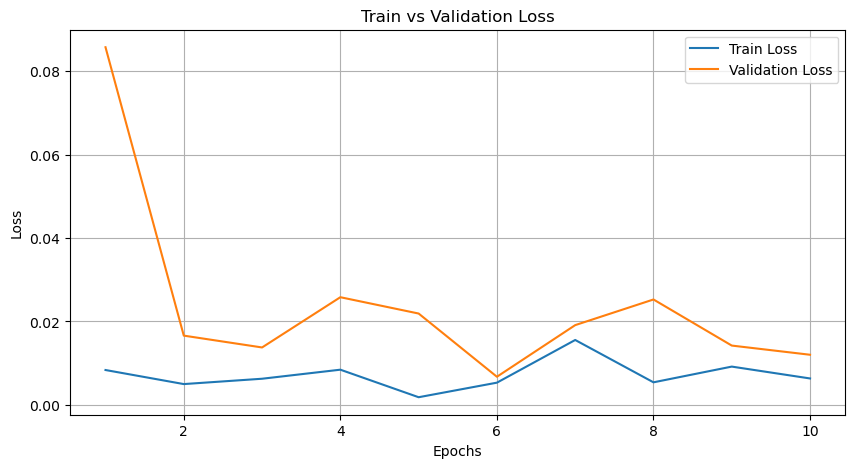

In [27]:
train_losses, val_losses = [], []

# Modify train_model to append losses to these lists
trained_model, train_losses, val_losses = train_model(model, train_dl, val_dl, device, epochs=10)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

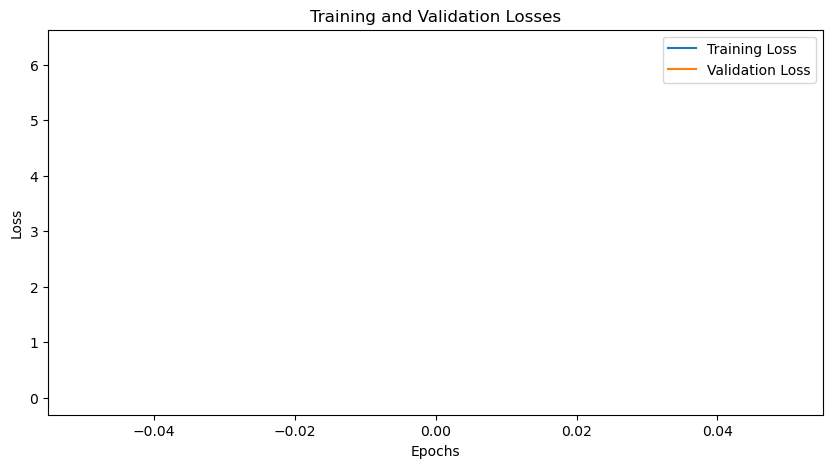

In [25]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [22]:
train_losses

5.1382936630398035